In [ ]:
# from google.colab import files
#
# uploaded = files.upload()
#
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
#
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# !cd /content/
# !kaggle datasets download -d siddharthkumarsah/ships-in-aerial-images
# !unzip ships-in-aerial-images.zip

# **Imports**

In [8]:
!pip install super-gradients==3.1.1


  Using cached super_gradients-3.1.1-py3-none-any.whl (964 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 726.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.6 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6

In [1]:
!pip install --upgrade pillow
!pip install --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 23.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 19.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 49.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━

In [2]:
import os
import random
import torch
import requests

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2023-06-16 17:03:46] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Super gradients YOLO import


# Config

In [62]:
class config:
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = 'vesselFinder'
    DATA_DIR = '/kaggle/input/ships-in-aerial-images/ships-aerial-images'
    TRAIN_IMAGES_DIR = 'train/images'
    TRAIN_LABELS_DIR = 'train/labels'

    VAL_IMAGES_DIR = 'valid/images'
    VAL_LABELS_DIR = 'valid/labels'

    TEST_IMAGES_DIR = 'test/images'
    TEST_LABELS_DIR = 'test/labels'

    CLASSES = ['ship']
    NUM_CLASSES = len(CLASSES)

    DATALOADER_PARAMS={
    'batch_size':8,
    'num_workers':2
    }

    MODEL_NAME = 'yolo_nas_l'
    PRETRAINED_WEIGHTS = 'coco'



In [22]:
trainer = Trainer(experiment_name = config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [23]:
train_data= coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)
test_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 9697/9697 [02:45<00:00, 58.44it/s]
[2023-06-16 17:11:34] WARNING - detection_dataset.py - Found 497 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
Caching annotations: 100%|██████████| 2165/2165 [00:34<00:00, 62.54it/s]
[2023-06-16 17:12:10] WARNING - detection_dataset.py - Found 113 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
Caching annotations: 100%|██████████| 1573/1573 [00:24<00:00, 64.20it/s]
[2023-06-16 17:12:35] WARNING - detection_dataset.py - Found 68 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.


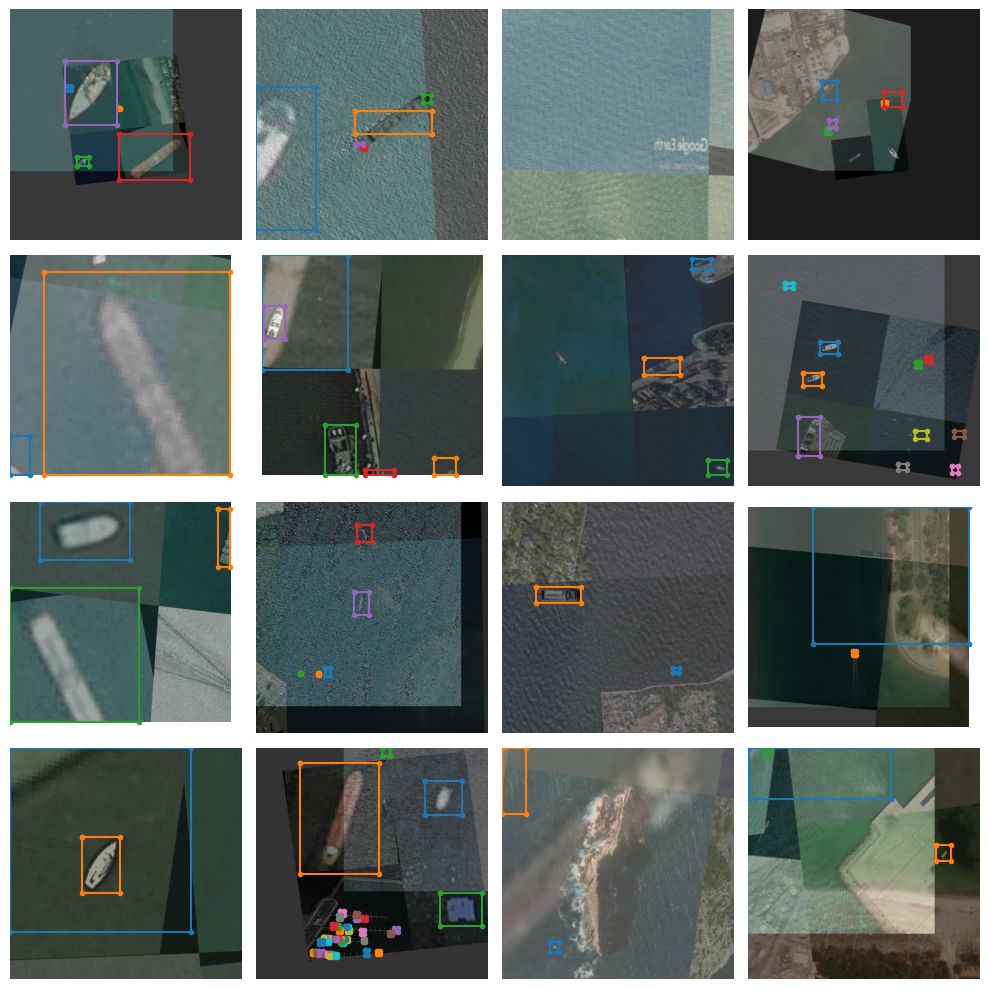

In [24]:
train_data.dataset.plot()

# Model

In [25]:
model = models.get(config.MODEL_NAME,num_classes=config.NUM_CLASSES,pretrained_weights=config.PRETRAINED_WEIGHTS)

[2023-06-16 17:13:29] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:01<00:00, 206MB/s] 


# Training parameters

In [50]:
train_params = {
    # ENABLING SILENT MODE
    #"resume":True,
    "device": "cuda",  # Use CUDA for GPU acceleration
    "parallel": True,  # Enable parallel training on multiple GPUs
    "num_gpus": 2,     # Number of GPUs to use
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
        "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Training

In [51]:
trainer.train(model=model,training_params=train_params,train_loader=train_data,valid_loader=val_data)

[2023-06-16 17:45:05] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/vesselFinder/console_Jun16_17_45_05.txt


[2023-06-16 17:45:08] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Dataset size:                 9245       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1155       (len(train_loader))
    - Gradient updates per epoch:   1155       (len(train_loader) / batch_accumulate)

[2023-06-16 17:45:08] INFO - sg_trainer.py - Started training for 20 epochs (0/19)

Validation epoch 0: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 2.4154
│   ├── Ppyoloeloss/loss_cls = 1.1233
│   ├── Ppyoloeloss/loss_dfl = 1.298
│   └── Ppyoloeloss/loss_iou = 0.2573
└── Validation
    ├── F1@0.50 = 0.0298
    ├── Map@0.50 = 0.2816
    ├── Ppyoloeloss/loss = 2.4579
    ├── Ppyoloeloss/loss_cls = 1.1761
    ├── Ppyoloeloss/loss_dfl = 1.2385
    ├── Ppyoloeloss/loss_iou = 0.265
    ├── Precision@0.50 = 0.0152
    └── Recall@0.50 = 0.6123



[2023-06-16 17:59:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 17:59:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.28158730268478394
Validation epoch 1: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.4585
│   │   ├── Best until now = 2.4154 (↗ 0.0431)
│   │   └── Epoch N-1      = 2.4154 (↗ 0.0431)
│   ├── Ppyoloeloss/loss_cls = 1.1613
│   │   ├── Best until now = 1.1233 (↗ 0.038)
│   │   └── Epoch N-1      = 1.1233 (↗ 0.038)
│   ├── Ppyoloeloss/loss_dfl = 1.313
│   │   ├── Best until now = 1.298  (↗ 0.015)
│   │   └── Epoch N-1      = 1.298  (↗ 0.015)
│   └── Ppyoloeloss/loss_iou = 0.2563
│       ├── Best until now = 0.2573 (↘ -0.001)
│       └── Epoch N-1      = 0.2573 (↘ -0.001)
└── Validation
    ├── F1@0.50 = 0.0273
    │   ├── Best until now = 0.0298 (↘ -0.0024)
    │   └── Epoch N-1      = 0.0298 (↘ -0.0024)
    ├── Map@0.50 = 0.2711
    │   ├── Best until now = 0.2816 (↘ -0.0105)
    │   └── Epoch N-1      = 0.2816 (↘ -0.0105)
    ├── Ppyoloeloss/loss = 2.4806
    │   ├── Best until now = 2.4579 (↗ 0.0227)
    │   └── Epoch N-1      = 2.4579 (↗ 0.0227)
    ├── Ppyoloeloss/loss_cls = 1.2474
    │   ├── Best until no

Validation epoch 2: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.4362
│   │   ├── Best until now = 2.4154 (↗ 0.0208)
│   │   └── Epoch N-1      = 2.4585 (↘ -0.0223)
│   ├── Ppyoloeloss/loss_cls = 1.1634
│   │   ├── Best until now = 1.1233 (↗ 0.0401)
│   │   └── Epoch N-1      = 1.1613 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 1.2954
│   │   ├── Best until now = 1.298  (↘ -0.0026)
│   │   └── Epoch N-1      = 1.313  (↘ -0.0176)
│   └── Ppyoloeloss/loss_iou = 0.2501
│       ├── Best until now = 0.2563 (↘ -0.0062)
│       └── Epoch N-1      = 0.2563 (↘ -0.0062)
└── Validation
    ├── F1@0.50 = 0.0348
    │   ├── Best until now = 0.0298 (↗ 0.005)
    │   └── Epoch N-1      = 0.0273 (↗ 0.0074)
    ├── Map@0.50 = 0.2745
    │   ├── Best until now = 0.2816 (↘ -0.0071)
    │   └── Epoch N-1      = 0.2711 (↗ 0.0034)
    ├── Ppyoloeloss/loss = 2.3748
    │   ├── Best until now = 2.4579 (↘ -0.0831)
    │   └── Epoch N-1      = 2.4806 (↘ -0.1058)
    ├── Ppyoloeloss/loss_cls = 1.1322
    │   ├── Best 

Validation epoch 3: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 2.4051
│   │   ├── Best until now = 2.4154 (↘ -0.0103)
│   │   └── Epoch N-1      = 2.4362 (↘ -0.0311)
│   ├── Ppyoloeloss/loss_cls = 1.1522
│   │   ├── Best until now = 1.1233 (↗ 0.0289)
│   │   └── Epoch N-1      = 1.1634 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_dfl = 1.2723
│   │   ├── Best until now = 1.2954 (↘ -0.0231)
│   │   └── Epoch N-1      = 1.2954 (↘ -0.0231)
│   └── Ppyoloeloss/loss_iou = 0.2467
│       ├── Best until now = 0.2501 (↘ -0.0034)
│       └── Epoch N-1      = 0.2501 (↘ -0.0034)
└── Validation
    ├── F1@0.50 = 0.0251
    │   ├── Best until now = 0.0348 (↘ -0.0096)
    │   └── Epoch N-1      = 0.0348 (↘ -0.0096)
    ├── Map@0.50 = 0.226
    │   ├── Best until now = 0.2816 (↘ -0.0555)
    │   └── Epoch N-1      = 0.2745 (↘ -0.0484)
    ├── Ppyoloeloss/loss = 2.5779
    │   ├── Best until now = 2.3748 (↗ 0.2031)
    │   └── Epoch N-1      = 2.3748 (↗ 0.2031)
    ├── Ppyoloeloss/loss_cls = 1.2972
    │   ├── Be

Validation epoch 4: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 2.3402
│   │   ├── Best until now = 2.4051 (↘ -0.0649)
│   │   └── Epoch N-1      = 2.4051 (↘ -0.0649)
│   ├── Ppyoloeloss/loss_cls = 1.1263
│   │   ├── Best until now = 1.1233 (↗ 0.003)
│   │   └── Epoch N-1      = 1.1522 (↘ -0.0259)
│   ├── Ppyoloeloss/loss_dfl = 1.2377
│   │   ├── Best until now = 1.2723 (↘ -0.0347)
│   │   └── Epoch N-1      = 1.2723 (↘ -0.0347)
│   └── Ppyoloeloss/loss_iou = 0.238
│       ├── Best until now = 0.2467 (↘ -0.0086)
│       └── Epoch N-1      = 0.2467 (↘ -0.0086)
└── Validation
    ├── F1@0.50 = 0.025
    │   ├── Best until now = 0.0348 (↘ -0.0097)
    │   └── Epoch N-1      = 0.0251 (↘ -0.0001)
    ├── Map@0.50 = 0.2473
    │   ├── Best until now = 0.2816 (↘ -0.0343)
    │   └── Epoch N-1      = 0.226  (↗ 0.0213)
    ├── Ppyoloeloss/loss = 2.5827
    │   ├── Best until now = 2.3748 (↗ 0.2079)
    │   └── Epoch N-1      = 2.5779 (↗ 0.0048)
    ├── Ppyoloeloss/loss_cls = 1.2975
    │   ├── Best 

Validation epoch 5: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 2.2941
│   │   ├── Best until now = 2.3402 (↘ -0.0461)
│   │   └── Epoch N-1      = 2.3402 (↘ -0.0461)
│   ├── Ppyoloeloss/loss_cls = 1.1088
│   │   ├── Best until now = 1.1233 (↘ -0.0145)
│   │   └── Epoch N-1      = 1.1263 (↘ -0.0175)
│   ├── Ppyoloeloss/loss_dfl = 1.205
│   │   ├── Best until now = 1.2377 (↘ -0.0326)
│   │   └── Epoch N-1      = 1.2377 (↘ -0.0326)
│   └── Ppyoloeloss/loss_iou = 0.2331
│       ├── Best until now = 0.238  (↘ -0.0049)
│       └── Epoch N-1      = 0.238  (↘ -0.0049)
└── Validation
    ├── F1@0.50 = 0.0313
    │   ├── Best until now = 0.0348 (↘ -0.0034)
    │   └── Epoch N-1      = 0.025  (↗ 0.0063)
    ├── Map@0.50 = 0.3188
    │   ├── Best until now = 0.2816 (↗ 0.0373)
    │   └── Epoch N-1      = 0.2473 (↗ 0.0716)
    ├── Ppyoloeloss/loss = 2.3798
    │   ├── Best until now = 2.3748 (↗ 0.005)
    │   └── Epoch N-1      = 2.5827 (↘ -0.203)
    ├── Ppyoloeloss/loss_cls = 1.1712
    │   ├── Best 

[2023-06-16 19:12:07] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 19:12:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.31884875893592834
Validation epoch 6: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 2.2617
│   │   ├── Best until now = 2.2941 (↘ -0.0325)
│   │   └── Epoch N-1      = 2.2941 (↘ -0.0325)
│   ├── Ppyoloeloss/loss_cls = 1.0972
│   │   ├── Best until now = 1.1088 (↘ -0.0116)
│   │   └── Epoch N-1      = 1.1088 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_dfl = 1.1816
│   │   ├── Best until now = 1.205  (↘ -0.0234)
│   │   └── Epoch N-1      = 1.205  (↘ -0.0234)
│   └── Ppyoloeloss/loss_iou = 0.2295
│       ├── Best until now = 0.2331 (↘ -0.0037)
│       └── Epoch N-1      = 0.2331 (↘ -0.0037)
└── Validation
    ├── F1@0.50 = 0.0275
    │   ├── Best until now = 0.0348 (↘ -0.0072)
    │   └── Epoch N-1      = 0.0313 (↘ -0.0038)
    ├── Map@0.50 = 0.3109
    │   ├── Best until now = 0.3188 (↘ -0.0079)
    │   └── Epoch N-1      = 0.3188 (↘ -0.0079)
    ├── Ppyoloeloss/loss = 2.3953
    │   ├── Best until now = 2.3748 (↗ 0.0205)
    │   └── Epoch N-1      = 2.3798 (↗ 0.0155)
    ├── Ppyoloeloss/loss_cls = 1.1887
    │   ├── 

Validation epoch 7: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 2.2195
│   │   ├── Best until now = 2.2617 (↘ -0.0422)
│   │   └── Epoch N-1      = 2.2617 (↘ -0.0422)
│   ├── Ppyoloeloss/loss_cls = 1.076
│   │   ├── Best until now = 1.0972 (↘ -0.0212)
│   │   └── Epoch N-1      = 1.0972 (↘ -0.0212)
│   ├── Ppyoloeloss/loss_dfl = 1.1579
│   │   ├── Best until now = 1.1816 (↘ -0.0237)
│   │   └── Epoch N-1      = 1.1816 (↘ -0.0237)
│   └── Ppyoloeloss/loss_iou = 0.2258
│       ├── Best until now = 0.2295 (↘ -0.0037)
│       └── Epoch N-1      = 0.2295 (↘ -0.0037)
└── Validation
    ├── F1@0.50 = 0.0263
    │   ├── Best until now = 0.0348 (↘ -0.0084)
    │   └── Epoch N-1      = 0.0275 (↘ -0.0012)
    ├── Map@0.50 = 0.2939
    │   ├── Best until now = 0.3188 (↘ -0.0249)
    │   └── Epoch N-1      = 0.3109 (↘ -0.017)
    ├── Ppyoloeloss/loss = 2.4104
    │   ├── Best until now = 2.3748 (↗ 0.0356)
    │   └── Epoch N-1      = 2.3953 (↗ 0.0151)
    ├── Ppyoloeloss/loss_cls = 1.1945
    │   ├── Be

Validation epoch 8: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 2.1862
│   │   ├── Best until now = 2.2195 (↘ -0.0332)
│   │   └── Epoch N-1      = 2.2195 (↘ -0.0332)
│   ├── Ppyoloeloss/loss_cls = 1.06
│   │   ├── Best until now = 1.076  (↘ -0.016)
│   │   └── Epoch N-1      = 1.076  (↘ -0.016)
│   ├── Ppyoloeloss/loss_dfl = 1.1403
│   │   ├── Best until now = 1.1579 (↘ -0.0176)
│   │   └── Epoch N-1      = 1.1579 (↘ -0.0176)
│   └── Ppyoloeloss/loss_iou = 0.2224
│       ├── Best until now = 0.2258 (↘ -0.0034)
│       └── Epoch N-1      = 0.2258 (↘ -0.0034)
└── Validation
    ├── F1@0.50 = 0.0392
    │   ├── Best until now = 0.0348 (↗ 0.0045)
    │   └── Epoch N-1      = 0.0263 (↗ 0.0129)
    ├── Map@0.50 = 0.3058
    │   ├── Best until now = 0.3188 (↘ -0.0131)
    │   └── Epoch N-1      = 0.2939 (↗ 0.0118)
    ├── Ppyoloeloss/loss = 2.305
    │   ├── Best until now = 2.3748 (↘ -0.0698)
    │   └── Epoch N-1      = 2.4104 (↘ -0.1054)
    ├── Ppyoloeloss/loss_cls = 1.1158
    │   ├── Best u

Validation epoch 9: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 2.1467
│   │   ├── Best until now = 2.1862 (↘ -0.0395)
│   │   └── Epoch N-1      = 2.1862 (↘ -0.0395)
│   ├── Ppyoloeloss/loss_cls = 1.0426
│   │   ├── Best until now = 1.06   (↘ -0.0174)
│   │   └── Epoch N-1      = 1.06   (↘ -0.0174)
│   ├── Ppyoloeloss/loss_dfl = 1.1121
│   │   ├── Best until now = 1.1403 (↘ -0.0282)
│   │   └── Epoch N-1      = 1.1403 (↘ -0.0282)
│   └── Ppyoloeloss/loss_iou = 0.2192
│       ├── Best until now = 0.2224 (↘ -0.0032)
│       └── Epoch N-1      = 0.2224 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.0329
    │   ├── Best until now = 0.0392 (↘ -0.0063)
    │   └── Epoch N-1      = 0.0392 (↘ -0.0063)
    ├── Map@0.50 = 0.3355
    │   ├── Best until now = 0.3188 (↗ 0.0167)
    │   └── Epoch N-1      = 0.3058 (↗ 0.0297)
    ├── Ppyoloeloss/loss = 2.2817
    │   ├── Best until now = 2.305  (↘ -0.0233)
    │   └── Epoch N-1      = 2.305  (↘ -0.0233)
    ├── Ppyoloeloss/loss_cls = 1.1336
    │   ├── 

[2023-06-16 20:11:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 20:11:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.33551025390625
Validation epoch 10: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 2.1158
│   │   ├── Best until now = 2.1467 (↘ -0.0309)
│   │   └── Epoch N-1      = 2.1467 (↘ -0.0309)
│   ├── Ppyoloeloss/loss_cls = 1.0241
│   │   ├── Best until now = 1.0426 (↘ -0.0184)
│   │   └── Epoch N-1      = 1.0426 (↘ -0.0184)
│   ├── Ppyoloeloss/loss_dfl = 1.1058
│   │   ├── Best until now = 1.1121 (↘ -0.0063)
│   │   └── Epoch N-1      = 1.1121 (↘ -0.0063)
│   └── Ppyoloeloss/loss_iou = 0.2155
│       ├── Best until now = 0.2192 (↘ -0.0037)
│       └── Epoch N-1      = 0.2192 (↘ -0.0037)
└── Validation
    ├── F1@0.50 = 0.0255
    │   ├── Best until now = 0.0392 (↘ -0.0138)
    │   └── Epoch N-1      = 0.0329 (↘ -0.0075)
    ├── Map@0.50 = 0.3527
    │   ├── Best until now = 0.3355 (↗ 0.0172)
    │   └── Epoch N-1      = 0.3355 (↗ 0.0172)
    ├── Ppyoloeloss/loss = 2.297
    │   ├── Best until now = 2.2817 (↗ 0.0153)
    │   └── Epoch N-1      = 2.2817 (↗ 0.0153)
    ├── Ppyoloeloss/loss_cls = 1.1533
    │   ├── Be

[2023-06-16 20:26:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 20:26:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3527466654777527
Validation epoch 11: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 2.0864
│   │   ├── Best until now = 2.1158 (↘ -0.0294)
│   │   └── Epoch N-1      = 2.1158 (↘ -0.0294)
│   ├── Ppyoloeloss/loss_cls = 1.0133
│   │   ├── Best until now = 1.0241 (↘ -0.0109)
│   │   └── Epoch N-1      = 1.0241 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_dfl = 1.085
│   │   ├── Best until now = 1.1058 (↘ -0.0208)
│   │   └── Epoch N-1      = 1.1058 (↘ -0.0208)
│   └── Ppyoloeloss/loss_iou = 0.2123
│       ├── Best until now = 0.2155 (↘ -0.0032)
│       └── Epoch N-1      = 0.2155 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.0433
    │   ├── Best until now = 0.0392 (↗ 0.0041)
    │   └── Epoch N-1      = 0.0255 (↗ 0.0179)
    ├── Map@0.50 = 0.3748
    │   ├── Best until now = 0.3527 (↗ 0.0221)
    │   └── Epoch N-1      = 0.3527 (↗ 0.0221)
    ├── Ppyoloeloss/loss = 2.2133
    │   ├── Best until now = 2.2817 (↘ -0.0684)
    │   └── Epoch N-1      = 2.297  (↘ -0.0837)
    ├── Ppyoloeloss/loss_cls = 1.05
    │   ├── Best

[2023-06-16 20:41:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 20:41:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3748393654823303
Validation epoch 12: 100%|██████████| 258/258 [01:35<00:00,  2.71it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 2.0549
│   │   ├── Best until now = 2.0864 (↘ -0.0315)
│   │   └── Epoch N-1      = 2.0864 (↘ -0.0315)
│   ├── Ppyoloeloss/loss_cls = 0.9965
│   │   ├── Best until now = 1.0133 (↘ -0.0167)
│   │   └── Epoch N-1      = 1.0133 (↘ -0.0167)
│   ├── Ppyoloeloss/loss_dfl = 1.0674
│   │   ├── Best until now = 1.085  (↘ -0.0175)
│   │   └── Epoch N-1      = 1.085  (↘ -0.0175)
│   └── Ppyoloeloss/loss_iou = 0.2099
│       ├── Best until now = 0.2123 (↘ -0.0024)
│       └── Epoch N-1      = 0.2123 (↘ -0.0024)
└── Validation
    ├── F1@0.50 = 0.034
    │   ├── Best until now = 0.0433 (↘ -0.0093)
    │   └── Epoch N-1      = 0.0433 (↘ -0.0093)
    ├── Map@0.50 = 0.387
    │   ├── Best until now = 0.3748 (↗ 0.0122)
    │   └── Epoch N-1      = 0.3748 (↗ 0.0122)
    ├── Ppyoloeloss/loss = 2.1828
    │   ├── Best until now = 2.2133 (↘ -0.0305)
    │   └── Epoch N-1      = 2.2133 (↘ -0.0305)
    ├── Ppyoloeloss/loss_cls = 1.0742
    │   ├── B

[2023-06-16 20:55:54] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 20:55:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.38704225420951843
Validation epoch 13: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 2.0336
│   │   ├── Best until now = 2.0549 (↘ -0.0213)
│   │   └── Epoch N-1      = 2.0549 (↘ -0.0213)
│   ├── Ppyoloeloss/loss_cls = 0.9867
│   │   ├── Best until now = 0.9965 (↘ -0.0099)
│   │   └── Epoch N-1      = 0.9965 (↘ -0.0099)
│   ├── Ppyoloeloss/loss_dfl = 1.0562
│   │   ├── Best until now = 1.0674 (↘ -0.0112)
│   │   └── Epoch N-1      = 1.0674 (↘ -0.0112)
│   └── Ppyoloeloss/loss_iou = 0.2075
│       ├── Best until now = 0.2099 (↘ -0.0023)
│       └── Epoch N-1      = 0.2099 (↘ -0.0023)
└── Validation
    ├── F1@0.50 = 0.0303
    │   ├── Best until now = 0.0433 (↘ -0.013)
    │   └── Epoch N-1      = 0.034  (↘ -0.0037)
    ├── Map@0.50 = 0.3835
    │   ├── Best until now = 0.387  (↘ -0.0035)
    │   └── Epoch N-1      = 0.387  (↘ -0.0035)
    ├── Ppyoloeloss/loss = 2.2105
    │   ├── Best until now = 2.1828 (↗ 0.0277)
    │   └── Epoch N-1      = 2.1828 (↗ 0.0277)
    ├── Ppyoloeloss/loss_cls = 1.1009
    │   ├── 

Validation epoch 14: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 2.0025
│   │   ├── Best until now = 2.0336 (↘ -0.0311)
│   │   └── Epoch N-1      = 2.0336 (↘ -0.0311)
│   ├── Ppyoloeloss/loss_cls = 0.9704
│   │   ├── Best until now = 0.9867 (↘ -0.0162)
│   │   └── Epoch N-1      = 0.9867 (↘ -0.0162)
│   ├── Ppyoloeloss/loss_dfl = 1.0416
│   │   ├── Best until now = 1.0562 (↘ -0.0146)
│   │   └── Epoch N-1      = 1.0562 (↘ -0.0146)
│   └── Ppyoloeloss/loss_iou = 0.2045
│       ├── Best until now = 0.2075 (↘ -0.003)
│       └── Epoch N-1      = 0.2075 (↘ -0.003)
└── Validation
    ├── F1@0.50 = 0.0381
    │   ├── Best until now = 0.0433 (↘ -0.0052)
    │   └── Epoch N-1      = 0.0303 (↗ 0.0078)
    ├── Map@0.50 = 0.4021
    │   ├── Best until now = 0.387  (↗ 0.015)
    │   └── Epoch N-1      = 0.3835 (↗ 0.0186)
    ├── Ppyoloeloss/loss = 2.1562
    │   ├── Best until now = 2.1828 (↘ -0.0266)
    │   └── Epoch N-1      = 2.2105 (↘ -0.0543)
    ├── Ppyoloeloss/loss_cls = 1.0398
    │   ├── Bes

[2023-06-16 21:25:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 21:25:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4020545482635498
Validation epoch 15: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.9763
│   │   ├── Best until now = 2.0025 (↘ -0.0262)
│   │   └── Epoch N-1      = 2.0025 (↘ -0.0262)
│   ├── Ppyoloeloss/loss_cls = 0.9605
│   │   ├── Best until now = 0.9704 (↘ -0.01)
│   │   └── Epoch N-1      = 0.9704 (↘ -0.01)
│   ├── Ppyoloeloss/loss_dfl = 1.0249
│   │   ├── Best until now = 1.0416 (↘ -0.0167)
│   │   └── Epoch N-1      = 1.0416 (↘ -0.0167)
│   └── Ppyoloeloss/loss_iou = 0.2013
│       ├── Best until now = 0.2045 (↘ -0.0031)
│       └── Epoch N-1      = 0.2045 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.0429
    │   ├── Best until now = 0.0433 (↘ -0.0004)
    │   └── Epoch N-1      = 0.0381 (↗ 0.0049)
    ├── Map@0.50 = 0.3978
    │   ├── Best until now = 0.4021 (↘ -0.0043)
    │   └── Epoch N-1      = 0.4021 (↘ -0.0043)
    ├── Ppyoloeloss/loss = 2.1485
    │   ├── Best until now = 2.1562 (↘ -0.0077)
    │   └── Epoch N-1      = 2.1562 (↘ -0.0077)
    ├── Ppyoloeloss/loss_cls = 1.039
    │   ├── Bes

Validation epoch 16: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.9679
│   │   ├── Best until now = 1.9763 (↘ -0.0084)
│   │   └── Epoch N-1      = 1.9763 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_cls = 0.9573
│   │   ├── Best until now = 0.9605 (↘ -0.0031)
│   │   └── Epoch N-1      = 0.9605 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 1.0244
│   │   ├── Best until now = 1.0249 (↘ -0.0005)
│   │   └── Epoch N-1      = 1.0249 (↘ -0.0005)
│   └── Ppyoloeloss/loss_iou = 0.1993
│       ├── Best until now = 0.2013 (↘ -0.002)
│       └── Epoch N-1      = 0.2013 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.0447
    │   ├── Best until now = 0.0433 (↗ 0.0014)
    │   └── Epoch N-1      = 0.0429 (↗ 0.0018)
    ├── Map@0.50 = 0.3968
    │   ├── Best until now = 0.4021 (↘ -0.0053)
    │   └── Epoch N-1      = 0.3978 (↘ -0.001)
    ├── Ppyoloeloss/loss = 2.1222
    │   ├── Best until now = 2.1485 (↘ -0.0263)
    │   └── Epoch N-1      = 2.1485 (↘ -0.0263)
    ├── Ppyoloeloss/loss_cls = 1.0204
    │   ├── Be

Validation epoch 17: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.947
│   │   ├── Best until now = 1.9679 (↘ -0.0209)
│   │   └── Epoch N-1      = 1.9679 (↘ -0.0209)
│   ├── Ppyoloeloss/loss_cls = 0.9473
│   │   ├── Best until now = 0.9573 (↘ -0.01)
│   │   └── Epoch N-1      = 0.9573 (↘ -0.01)
│   ├── Ppyoloeloss/loss_dfl = 1.0133
│   │   ├── Best until now = 1.0244 (↘ -0.0111)
│   │   └── Epoch N-1      = 1.0244 (↘ -0.0111)
│   └── Ppyoloeloss/loss_iou = 0.1972
│       ├── Best until now = 0.1993 (↘ -0.0021)
│       └── Epoch N-1      = 0.1993 (↘ -0.0021)
└── Validation
    ├── F1@0.50 = 0.0425
    │   ├── Best until now = 0.0447 (↘ -0.0022)
    │   └── Epoch N-1      = 0.0447 (↘ -0.0022)
    ├── Map@0.50 = 0.4112
    │   ├── Best until now = 0.4021 (↗ 0.0091)
    │   └── Epoch N-1      = 0.3968 (↗ 0.0144)
    ├── Ppyoloeloss/loss = 2.1039
    │   ├── Best until now = 2.1222 (↘ -0.0183)
    │   └── Epoch N-1      = 2.1222 (↘ -0.0183)
    ├── Ppyoloeloss/loss_cls = 1.0156
    │   ├── Best

[2023-06-16 22:10:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/vesselFinder/ckpt_best.pth
[2023-06-16 22:10:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4111626446247101
Validation epoch 18: 100%|██████████| 258/258 [01:34<00:00,  2.72it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.9376
│   │   ├── Best until now = 1.947  (↘ -0.0094)
│   │   └── Epoch N-1      = 1.947  (↘ -0.0094)
│   ├── Ppyoloeloss/loss_cls = 0.9434
│   │   ├── Best until now = 0.9473 (↘ -0.0039)
│   │   └── Epoch N-1      = 0.9473 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 1.0033
│   │   ├── Best until now = 1.0133 (↘ -0.01)
│   │   └── Epoch N-1      = 1.0133 (↘ -0.01)
│   └── Ppyoloeloss/loss_iou = 0.197
│       ├── Best until now = 0.1972 (↘ -0.0002)
│       └── Epoch N-1      = 0.1972 (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.0456
    │   ├── Best until now = 0.0447 (↗ 0.0008)
    │   └── Epoch N-1      = 0.0425 (↗ 0.0031)
    ├── Map@0.50 = 0.407
    │   ├── Best until now = 0.4112 (↘ -0.0041)
    │   └── Epoch N-1      = 0.4112 (↘ -0.0041)
    ├── Ppyoloeloss/loss = 2.119
    │   ├── Best until now = 2.1039 (↗ 0.0151)
    │   └── Epoch N-1      = 2.1039 (↗ 0.0151)
    ├── Ppyoloeloss/loss_cls = 1.0228
    │   ├── Best unt

Validation epoch 19: 100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.9336
│   │   ├── Best until now = 1.9376 (↘ -0.0041)
│   │   └── Epoch N-1      = 1.9376 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_cls = 0.9398
│   │   ├── Best until now = 0.9434 (↘ -0.0037)
│   │   └── Epoch N-1      = 0.9434 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 1.0033
│   │   ├── Best until now = 1.0033 (↘ -0.0)
│   │   └── Epoch N-1      = 1.0033 (↘ -0.0)
│   └── Ppyoloeloss/loss_iou = 0.1969
│       ├── Best until now = 0.197  (↘ -0.0002)
│       └── Epoch N-1      = 0.197  (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.0399
    │   ├── Best until now = 0.0456 (↘ -0.0057)
    │   └── Epoch N-1      = 0.0456 (↘ -0.0057)
    ├── Map@0.50 = 0.4073
    │   ├── Best until now = 0.4112 (↘ -0.0039)
    │   └── Epoch N-1      = 0.407  (↗ 0.0003)
    ├── Ppyoloeloss/loss = 2.1519
    │   ├── Best until now = 2.1039 (↗ 0.048)
    │   └── Epoch N-1      = 2.119  (↗ 0.033)
    ├── Ppyoloeloss/loss_cls = 1.0515
    │   ├── Best unt

[2023-06-16 22:40:24] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 20: 100%|██████████| 258/258 [01:34<00:00,  2.72it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.9336
│   │   ├── Best until now = 1.9376 (↘ -0.0041)
│   │   └── Epoch N-1      = 1.9376 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_cls = 0.9398
│   │   ├── Best until now = 0.9434 (↘ -0.0037)
│   │   └── Epoch N-1      = 0.9434 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 1.0033
│   │   ├── Best until now = 1.0033 (↘ -0.0)
│   │   └── Epoch N-1      = 1.0033 (↘ -0.0)
│   └── Ppyoloeloss/loss_iou = 0.1969
│       ├── Best until now = 0.197  (↘ -0.0002)
│       └── Epoch N-1      = 0.197  (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.0471
    │   ├── Best until now = 0.0456 (↗ 0.0016)
    │   └── Epoch N-1      = 0.0399 (↗ 0.0072)
    ├── Map@0.50 = 0.4105
    │   ├── Best until now = 0.4112 (↘ -0.0007)
    │   └── Epoch N-1      = 0.4073 (↗ 0.0032)
    ├── Ppyoloeloss/loss = 2.0677
    │   ├── Best until now = 2.1039 (↘ -0.0362)
    │   └── Epoch N-1      = 2.1519 (↘ -0.0842)
    ├── Ppyoloeloss/loss_cls = 1.0
    │   ├── Best unti

[2023-06-16 22:42:00] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [63]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2023-06-16 23:07:05] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/vesselFinder/average_model.pth EMA checkpoint.


In [64]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
               top_k_predictions=300,
               num_cls=config.NUM_CLASSES,
               normalize_targets=True,
               post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01,
                  nms_top_k=1000,
                  max_predictions=300,
                  nms_threshold=0.7)
               ))

Test: 100%|██████████| 187/187 [01:39<00:00,  2.29it/s]

{'PPYoloELoss/loss_cls': 1.0108737,
 'PPYoloELoss/loss_iou': 0.21546477,
 'PPYoloELoss/loss_dfl': 0.9969905,
 'PPYoloELoss/loss': 2.0480309,
 'Precision@0.50': tensor(0.0684),
 'Recall@0.50': tensor(0.6973),
 'mAP@0.50': tensor(0.4055),
 'F1@0.50': tensor(0.1245)}

Test: 100%|██████████| 187/187 [01:39<00:00,  1.87it/s]


In [67]:
tpaths=[]
for dirname, _, filenames in os.walk('/kaggle/input/ships-in-aerial-images/ships-aerial-images/test/images'):
    for filename in filenames:
        tpaths+=[(os.path.join(dirname, filename))]
tpaths2=random.sample(tpaths,10)

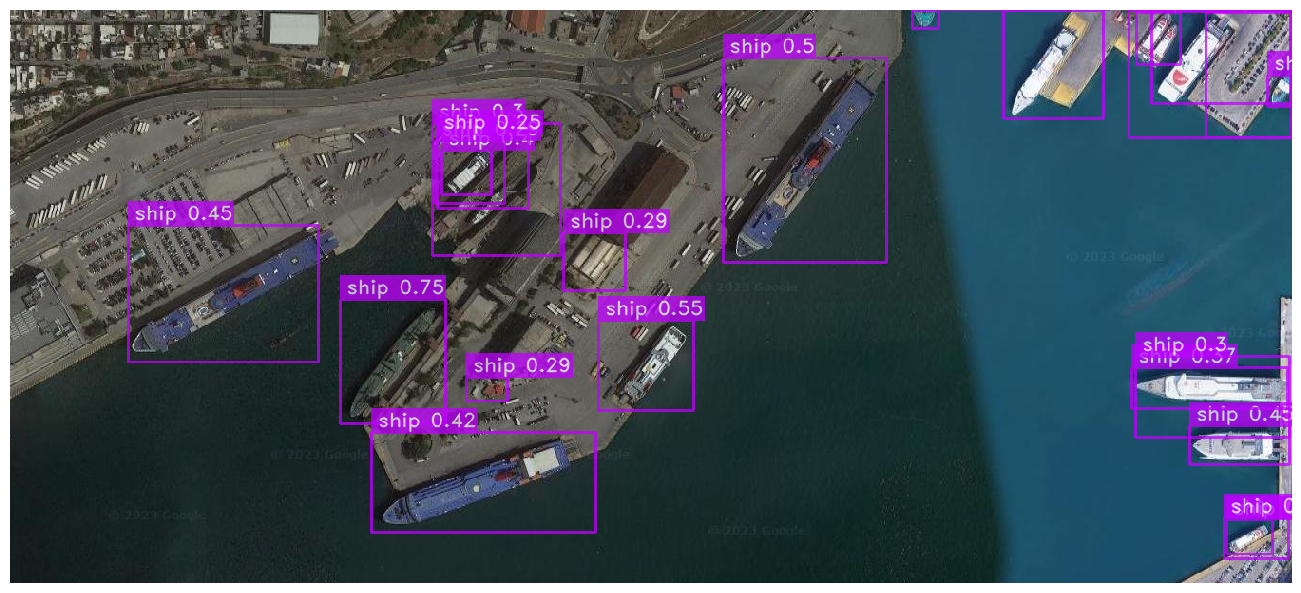

In [70]:
best_model.predict('/kaggle/input/random/2023-06-16 13_39_19-Google Maps.png', conf=0.25).show()
